In [120]:
import os 
import csv
import json
from tqdm import tqdm
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from scipy.stats import beta
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Default Parameters

In [84]:
MAIN_PATH     = f'/mnt/storage/jcheigh/fictitious-prediction'
SRC_PATH      = f'{MAIN_PATH}/src'
IMAGE_PATH    = f'{MAIN_PATH}/images'            
DATA_PATH     = f"{MAIN_PATH}/data"
CSV_FPATH     = f'{DATA_PATH}/results.csv'
SEED          = 10

In [121]:
pop_size = 1000
lex_size = 10
speech_len = 15
timesteps  = 1500
alpha_p    = 3
beta_p     = 3
a_mult     = 2
strength   = 2
epsilon    = 0.05
vocab_size = 3 * lex_size 
num_folds  = 5
scoring    = 'accuracy'

### Population Polarization Generation

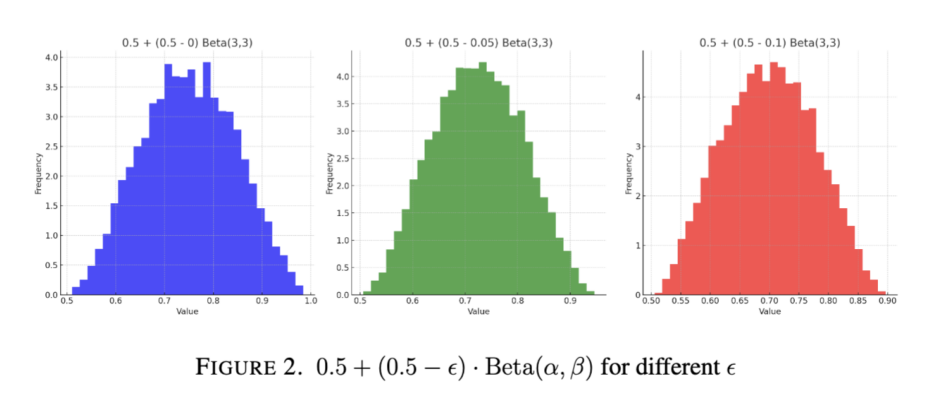

In [86]:
def get_rhos(eps=epsilon, a=alpha_p, b=beta_p, timesteps=timesteps):
    """
    generates rhos, i.e. a vector R where R[i] is the pop polarization at
    timestep i.
    """
    return .5 + (.5 - eps) * beta.rvs(a, b, size=timesteps)

rho_img_path = f'{IMAGE_PATH}/rho_gen.png' 
rho_img      = mpimg.imread(rho_img_path)
plt.figure(figsize=(12,8))
plt.imshow(rho_img)
plt.axis('off')
plt.show()

### Alpha/Beta Generation

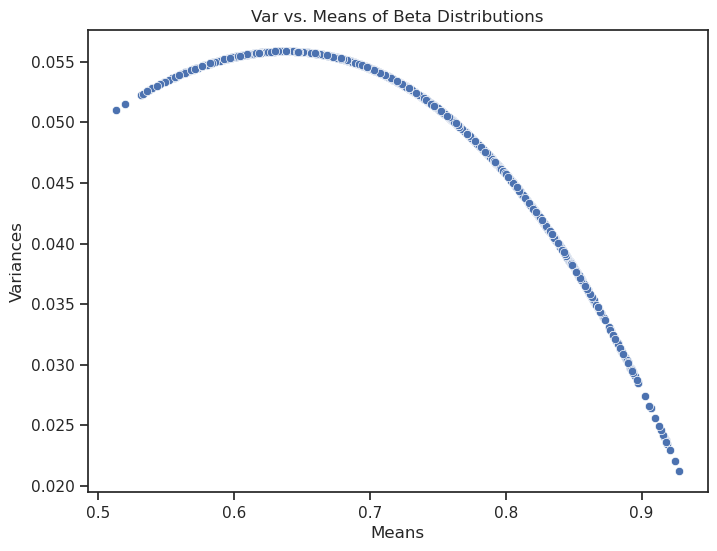

In [87]:
rhos   = get_rhos()
alphas = np.full(timesteps, a_mult)
betas  = a_mult * (1 - rhos) / rhos

def get_means(alphas=alphas, betas=betas):
    """returns means of beta distributions (should be rhos)"""
    return alphas / (alphas + betas)

def get_variances(alphas=alphas, betas=betas):
    """returns variances of beta distributions"""
    return alphas * betas / (((alphas + betas) ** 2) * (alphas + betas + 1))

means = get_means()
vars  = get_variances()
assert all(abs(means - rhos) < 1e-15)

plt.figure(figsize=(8,6))
sns.set(style='ticks')
p = sns.scatterplot(x=means, y=vars)
plt.title("Var vs. Means of Beta Distributions")
plt.ylabel('Variances')
plt.xlabel('Means')
plt.show()

This generation scheme makes an implict assumption that the variance takes on the following form- not problematic but something to potentially be aware of.

### Individual Polarization Generation

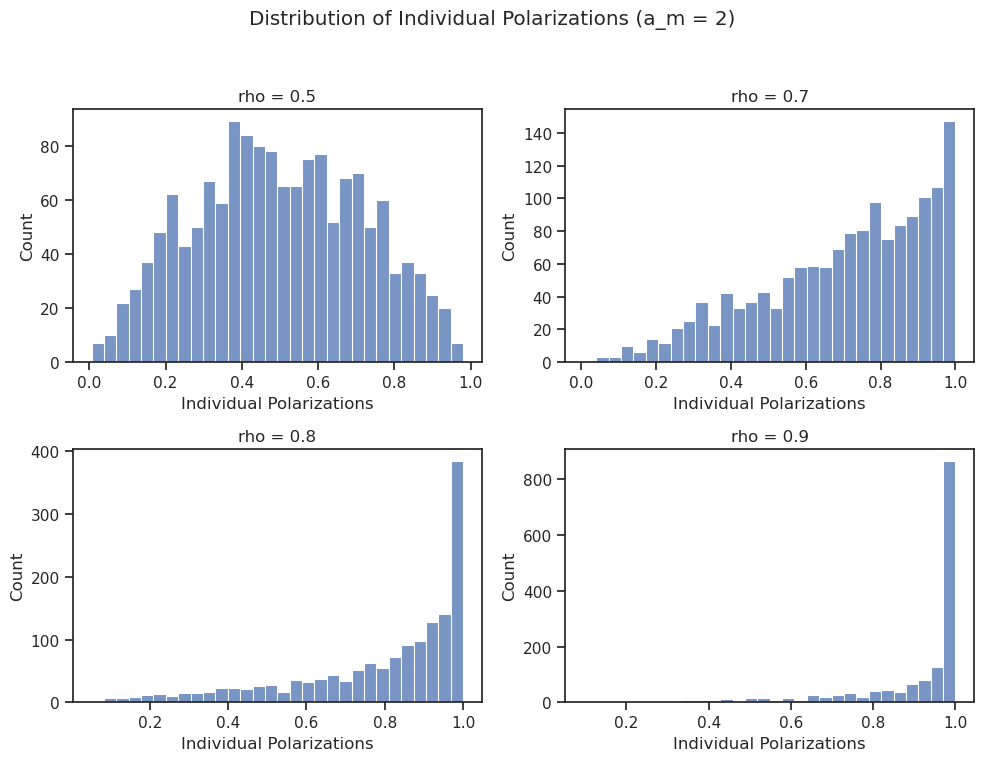

In [88]:
test_rhos   = np.array([.5, .7, .8, .9])
test_alphas = np.full(4, a_mult)
test_betas  = a_mult * (1 - test_rhos) / test_rhos

data = [beta.rvs(a, b, size=(timesteps)) for (a,b) in list(zip(test_alphas, test_betas))]


plt.figure(figsize=(10, 8))
plt.suptitle(f'Distribution of Individual Polarizations (a_m = {a_mult})')
for i in range(4):
    plt.subplot(2, 2, i+1) 
    sns.histplot(data[i], bins=30, kde=False)
    plt.title(f'rho = {test_rhos[i]}')
    plt.xlabel('Individual Polarizations')
    plt.ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

This is problematic. When $\rho = .9$, basically nobody will be left winged (since $y_i = 1(u_i \ge .5)$).

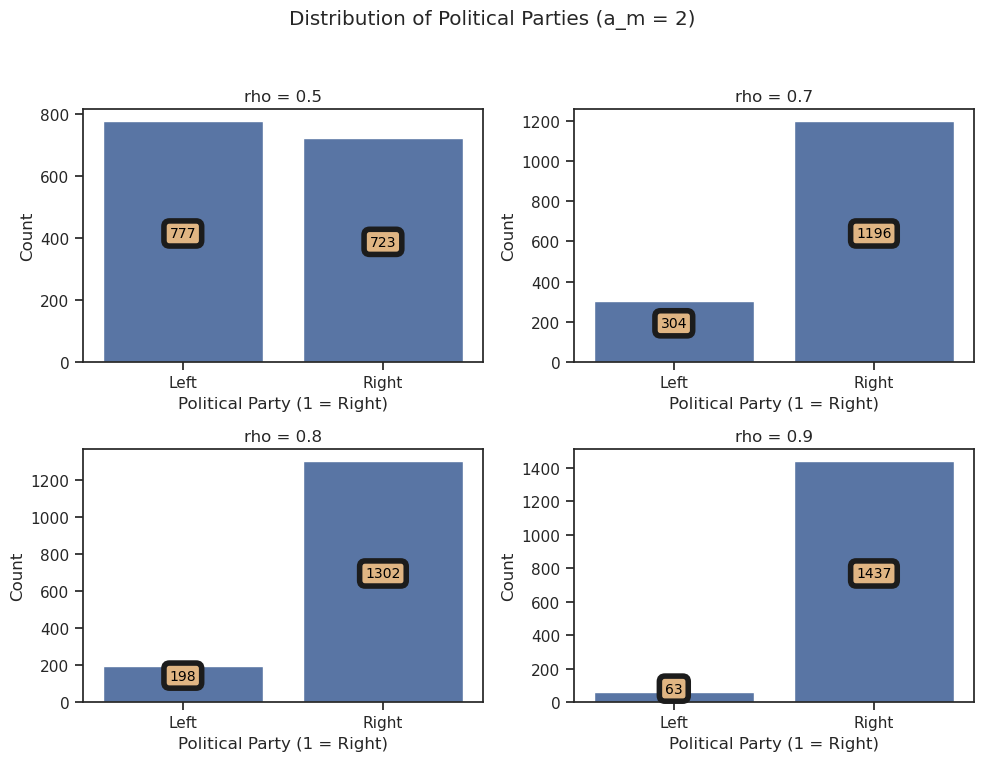

In [89]:
y_data = [(polar >= 0.5).astype(int) for polar in data]
y_data = [['Right' if y == 1 else 'Left' for y in polar] for polar in y_data]

plt.figure(figsize=(10, 8))
plt.suptitle(f'Distribution of Political Parties (a_m = {a_mult})')
for i in range(4):
    plt.subplot(2, 2, i+1) 
    p = sns.countplot(x = y_data[i], order = sorted(set(y_data[i])))

    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 10, color = "black", 
                bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                        "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})

    plt.title(f'rho = {test_rhos[i]}')
    plt.xlabel('Political Party (1 = Right)')
    plt.ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

This is bascially what I was trying to convey above.

### Phi Generation

In [90]:
polar_map = {}
for i, (a,b) in enumerate(list(zip(test_alphas, test_betas))):
    test_polars = beta.rvs(a, b, size=4)
    rho = test_rhos[i]
    polar_map[rho] = test_polars
    print(f'rho = {test_rhos[i]} -> polars = {[round(p, 2) for p in test_polars]}')

rho = 0.5 -> polars = [0.46, 0.2, 0.2, 0.98]
rho = 0.7 -> polars = [0.69, 0.51, 0.53, 0.87]
rho = 0.8 -> polars = [0.95, 0.45, 0.89, 0.93]
rho = 0.9 -> polars = [1.0, 1.0, 0.81, 1.0]


In [91]:
def get_phi(rho, u, eps=epsilon, L=lex_size):
    left_prob    = (u * (1 - rho - eps) + (1 - u) * rho) / L
    right_prob   = (u * rho + (1 - rho - eps) * (1 - u)) / L
    neutral_prob = (eps / L)
    phi = [left_prob] * L + [right_prob] * L + [neutral_prob] * L
    return phi

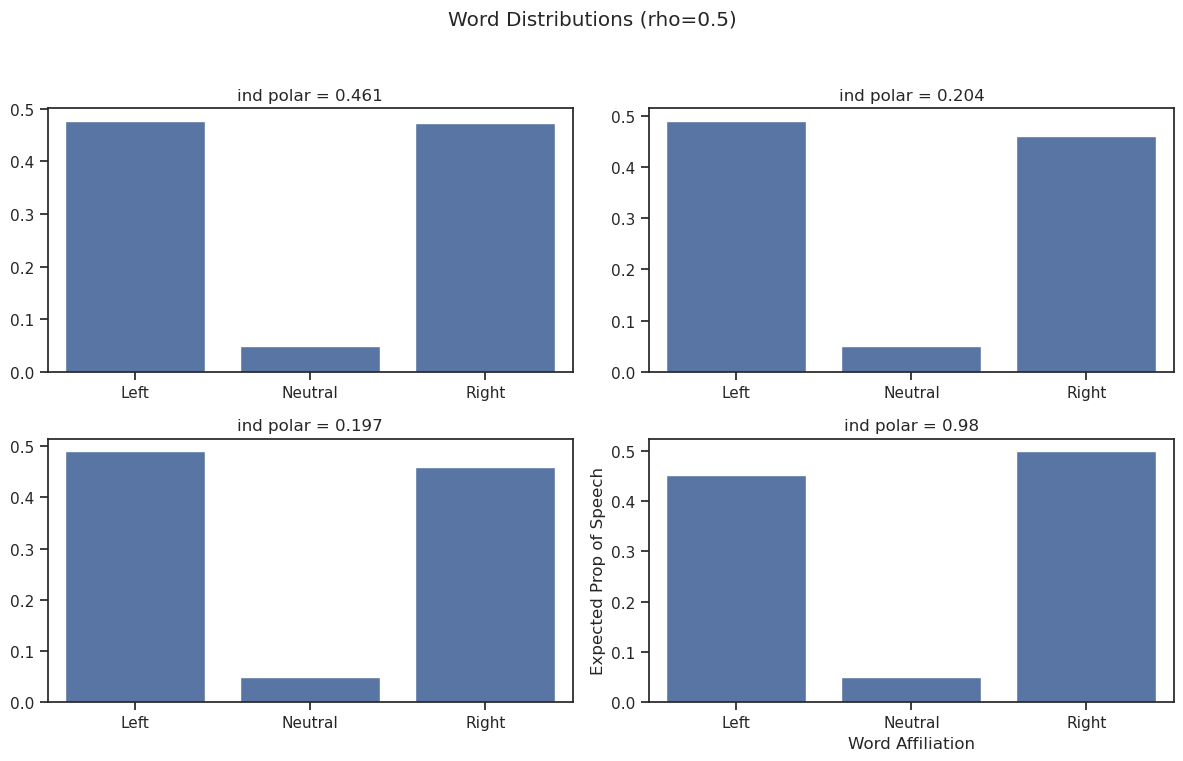

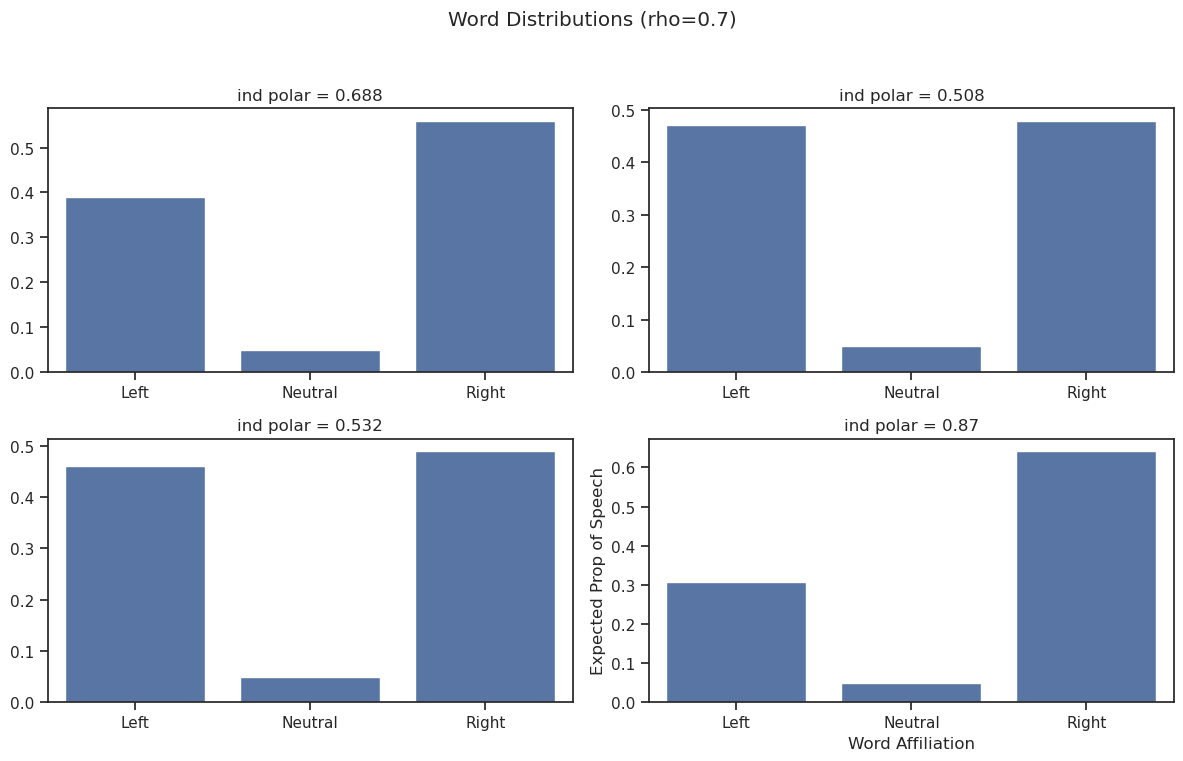

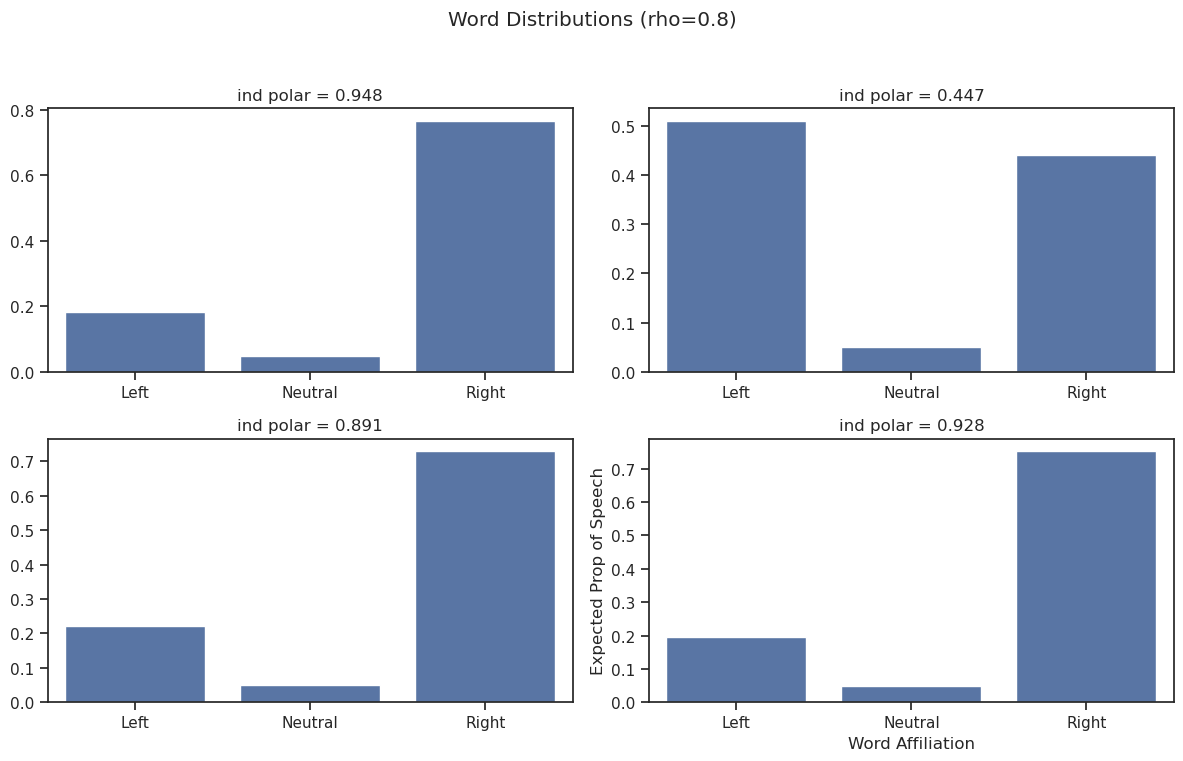

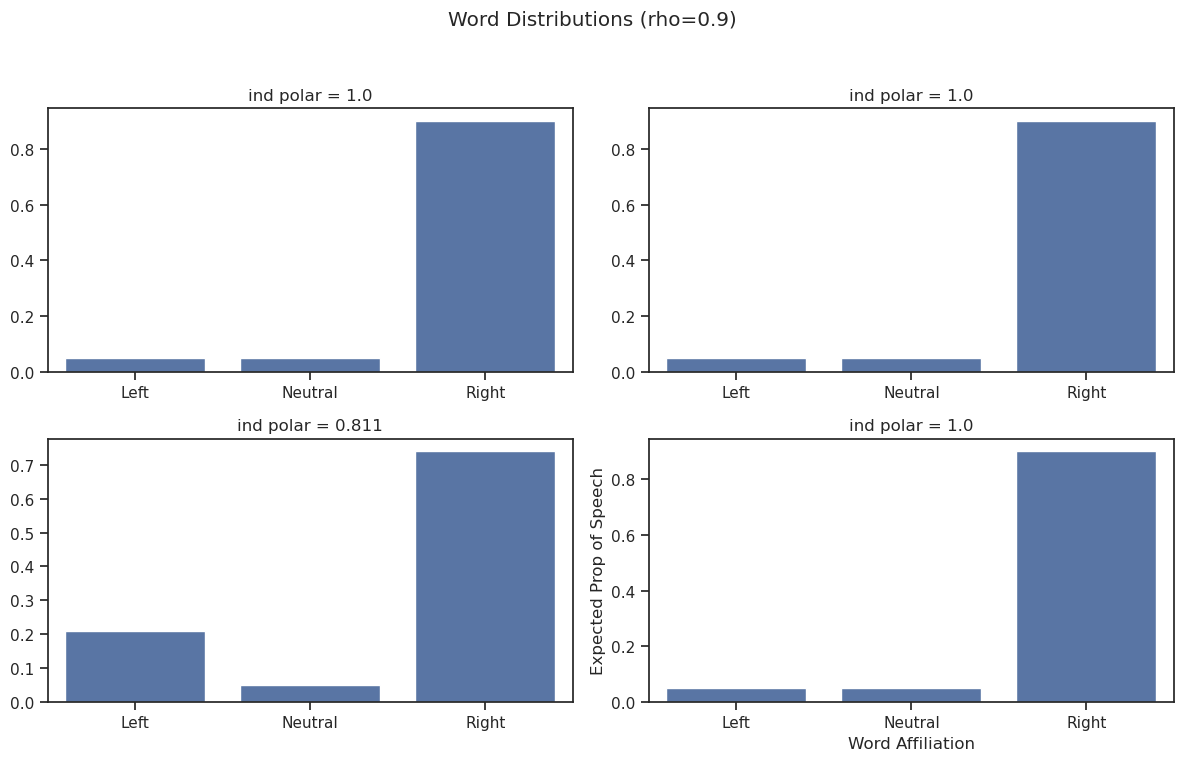

In [92]:
for rho, us in polar_map.items():
    fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 
    fig.suptitle(f"Word Distributions (rho={rho})")

    for i, u in enumerate(us):
        data = get_phi(rho, u)
        count_data = {
            'Left'   : lex_size * data[0],
            'Neutral': lex_size * data[-1],
            'Right'  : lex_size * data[lex_size]
        }
        categories = list(count_data.keys())
        counts = list(count_data.values())
        ax = plt.subplot(2, 2, i+1) 
        sns.barplot(x=categories, y=counts, ax=ax)
        ax.set_title(f'ind polar = {round(u, 3)}')

    plt.xlabel("Word Affiliation") 
    plt.ylabel("Expected Prop of Speech") 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [115]:

def generate(rho=.75):
    rhos = np.array([rho])
    timesteps = 1
    alphas = np.full(1, a_mult)
    betas = a_mult * (1 - rhos) / rhos
    polar = beta.rvs(alphas[:, np.newaxis], betas[:, np.newaxis], size=(timesteps, pop_size))
    y = (polar >= 0.5).astype(int)

    r = rhos[:, np.newaxis, np.newaxis]  
    polar_expanded = polar[:, :, np.newaxis]  

    left_prob    = (polar_expanded * (1 - r - epsilon) + (1 - polar_expanded) * r) / lex_size
    right_prob   = (polar_expanded * r + (1 - r - epsilon) * (1 - polar_expanded)) / lex_size
    neutral_prob = np.full(left_prob.shape, epsilon / lex_size)

    phi = np.concatenate([np.repeat(left_prob, lex_size, axis=2),
                        np.repeat(right_prob, lex_size, axis=2),
                        np.repeat(neutral_prob, lex_size, axis=2)], axis=2)

    X = np.array([[np.random.multinomial(speech_len, phi[t, i, :])
                for i in range(pop_size)] for t in range(timesteps)])

    data = [(X[t], y[t]) for t in range(timesteps)]

    return data

X, y = generate()[0]

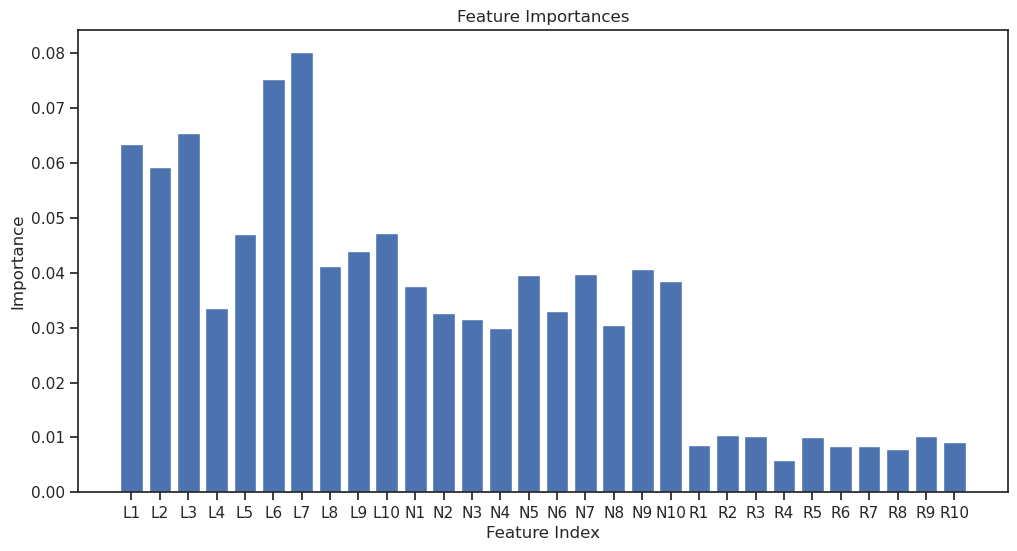

In [127]:
clf         = RandomForestClassifier(random_state=SEED)
grid_search = GridSearchCV(estimator=clf, param_grid={}, cv=num_folds, scoring=scoring)
grid_search.fit(X, y)
best_clf    = grid_search.best_estimator_

def get_feature(i):
    if i >= 20:
        return f'R{i-19}'
    elif i <= 9:
        return f'L{i+1}'
    return f"N{i-9}"

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar([get_feature(i) for i in range(X.shape[1])], best_clf.feature_importances_)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.xticks(range(X.shape[1]))
plt.show()

Here we see right words don't really matter (everything is a right word).